In [37]:
# import data handling libraries
import pandas as pd
import numpy as np
# import graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
# import stats libraries
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson, norm, chi2, ttest_ind, ttest_rel
from scipy import stats
from scipy import fft
from scipy.cluster.hierarchy import dendrogram, linkage
# from sklearn.cluster import AgglomerativeClustering


In [22]:
# load in the data
columns = [
    'Unique Meter ID', 
    'Unix Time Stamp', 
    'Date/Time Stamp', 
    'Incremental Consumption Value (Gallons)', 
    'Reading Value (Gallons)'
]
raw_df = pd.read_csv(
    'Sample_UtilityX_AMIData.csv', 
#                      names=columns, 
    header=None,
    index_col=False 
)

C:\Users\Russ\anaconda3\envs\data\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
# drop the meter size column because of missing data
raw_df = raw_df.loc[:,[0,1,2,3,4]]
raw_df.columns = columns
raw_df.head()

,Unique Meter ID,Unix Time Stamp,Date/Time Stamp,Incremental Consumption Value (Gallons),Reading Value (Gallons)
0,31793811,1489240800,2017-03-11 14:00:00,30,1049109.9
1,31793811,1489244400,2017-03-11 15:00:00,20,1049128.9
2,31793811,1489248000,2017-03-11 16:00:00,10,1049139.9
3,31793811,1489251600,2017-03-11 17:00:00,10,1049149.9
4,31793811,1489255200,2017-03-11 18:00:00,10,1049159.9


In [24]:
# convert datatype to datetime
raw_df['Date/Time Stamp'] = pd.to_datetime(raw_df['Date/Time Stamp'])

In [25]:
# make time-related columns for analysis over various periods
raw_df['dotw'] = raw_df['Date/Time Stamp'].dt.dayofweek
raw_df['hour'] = raw_df['Date/Time Stamp'].dt.hour
raw_df['doty'] = raw_df['Date/Time Stamp'].dt.dayofyear

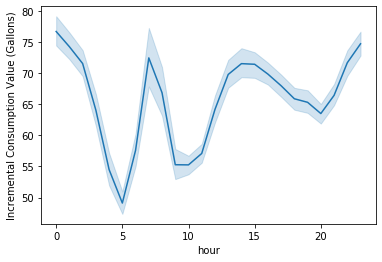

In [26]:
# first look at diurnal cycles
sns.lineplot(
    x='hour',
    y='Incremental Consumption Value (Gallons)',
    data=raw_df
)

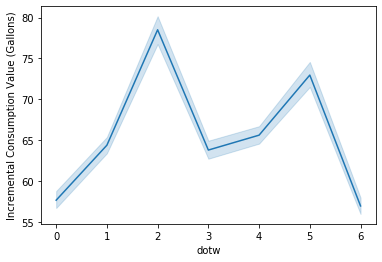

In [27]:
# first look at weekly cycles
# raw_df.groupby('dotw').agg({'Incremental Consumption Value (Gallons)':'mean'}).plot()

sns.lineplot(
    x='dotw',
    y='Incremental Consumption Value (Gallons)',
    data=raw_df
)

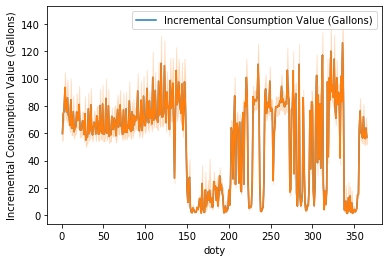

In [28]:
# first look at trend over the year
raw_df.groupby(['doty']).\
        agg({'Incremental Consumption Value (Gallons)':'mean'}).plot()

sns.lineplot(
    x='doty',
    y='Incremental Consumption Value (Gallons)',
    data=raw_df
)

# plt.ylim(0,130)

In [29]:
raw_df = raw_df.join(
    raw_df['Unique Meter ID'].value_counts(), 
    on='Unique Meter ID',
    rsuffix='000',
    how='left'
)

raw_df.columns

raw_df.columns = ['Unique Meter ID', 'Unix Time Stamp', 'Date/Time Stamp',
       'Incremental Consumption Value (Gallons)', 'Reading Value (Gallons)',
       'dotw', 'hour', 'doty', 'data_count']

In [30]:
365*24

8760

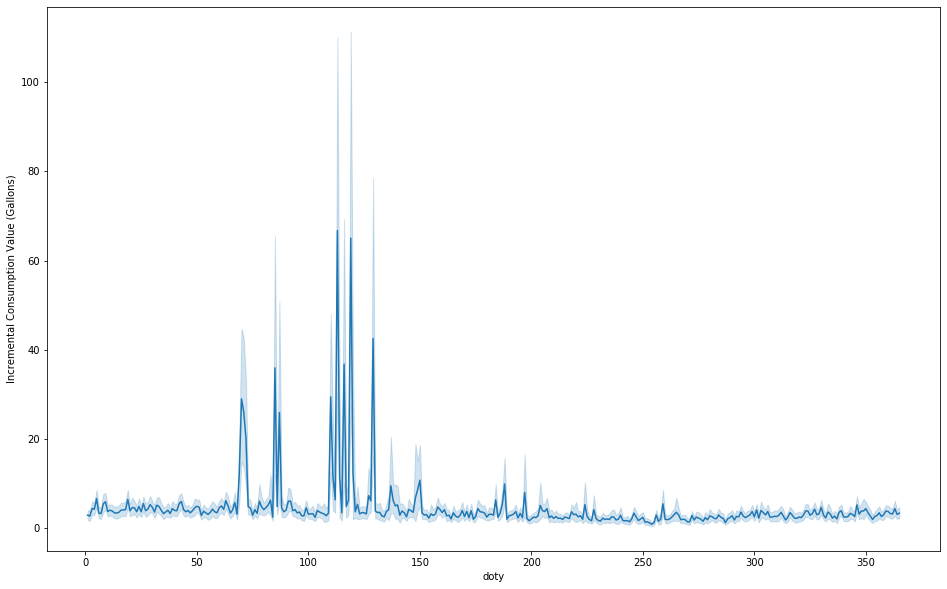

In [31]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
sns.lineplot(
    x='doty',
    y='Incremental Consumption Value (Gallons)',
    data=raw_df.loc[raw_df['data_count'] > 8700],
    ax=ax
)

In [57]:
daily_cons = raw_df.groupby(['Unique Meter ID', 'doty']).\
    agg({'Incremental Consumption Value (Gallons)':'sum'})

In [58]:
daily_cons.reset_index(inplace=True)

(-1, 300)

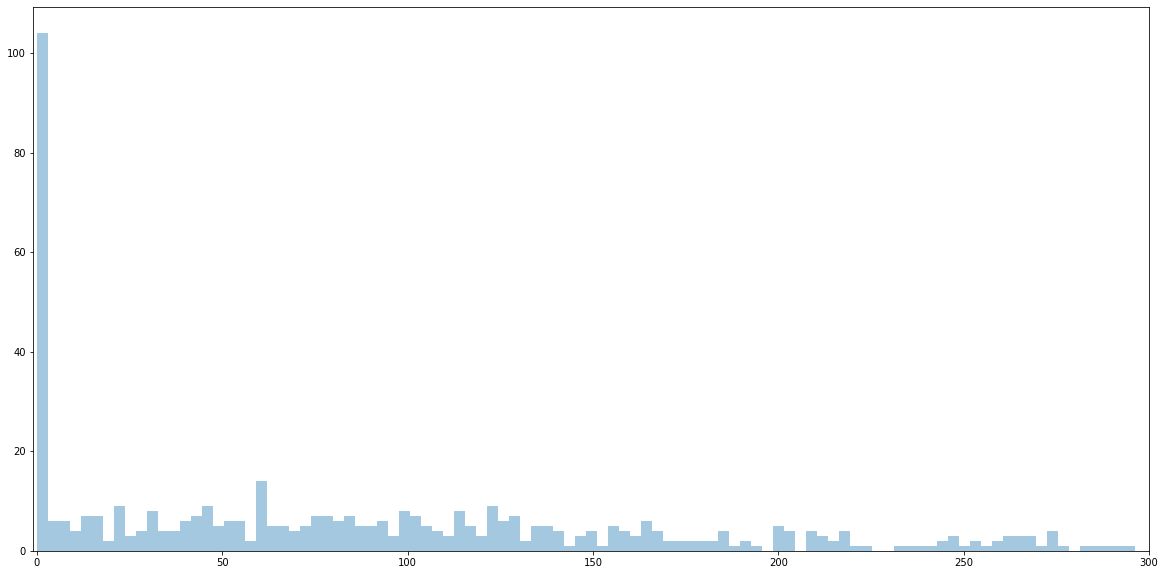

In [78]:
mean_plot = daily_cons.groupby('Unique Meter ID').agg({'Incremental Consumption Value (Gallons)':'mean'})
plt.figure(figsize=(20,10))
sns.distplot(
    mean_plot.loc[mean_plot['Incremental Consumption Value (Gallons)'] < 300],
    bins=100,
    kde=False,
    norm_hist=False
)
plt.xlim(-1,300)

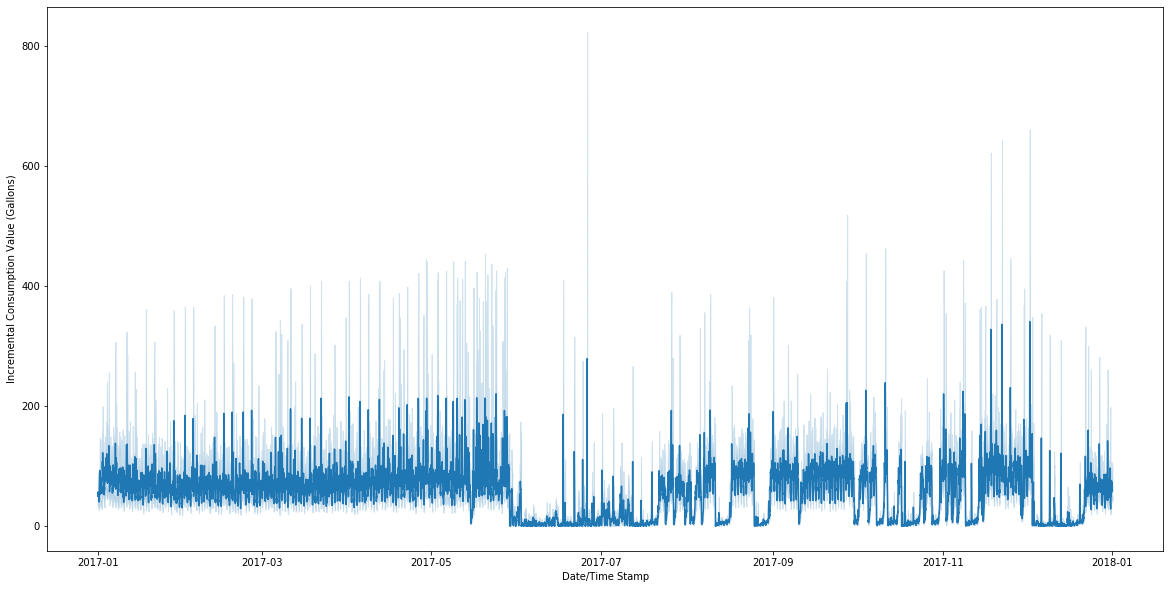

In [90]:
plt.figure(figsize=(20,10))
sns.lineplot(
    x='Date/Time Stamp',
    y='Incremental Consumption Value (Gallons)',
#     hue='Unique Meter ID',
    data=raw_df
)
# plt.ylim(0,200)

In [86]:
daily_cons3

,Unique Meter ID,doty,Incremental Consumption Value (Gallons)
0,20014711,204,0
1,20014711,205,0
2,20014711,206,0
3,20014711,207,10
4,20014711,208,0
...,...,...,...
113440,177343227,361,0
113441,177343227,362,0
113442,177343227,363,0
113443,177343227,364,0


In [54]:
raw_df.loc[raw_df['doty'] == 160, 'Unique Meter ID'].unique()

array([20388219, 20461623, 32084507, 31800193, 22186911, 20844163,
       20461839, 20644559, 20482781, 38785963, 35593623, 32039843,
       22192051, 22197471, 32109345, 22187523, 35372231, 32044331,
       34066141, 31800191], dtype=int64)

In [33]:
def ptp(col):
    output = {'max':col.max(),
              'min':col.min()}
    return output

print(
    'date time:', ptp(raw_df['Date/Time Stamp']),
    '\nwater consumption:', ptp(raw_df['Incremental Consumption Value (Gallons)'])
)

date time: {'max': Timestamp('2018-01-01 00:00:00'), 'min': Timestamp('2017-01-01 00:00:00')} 
water consumption: {'max': 41310, 'min': -1280}


In [39]:
temp = raw_df.pivot_table(
    index='hour',
    columns='doty',
    values='Incremental Consumption Value (Gallons)'
)

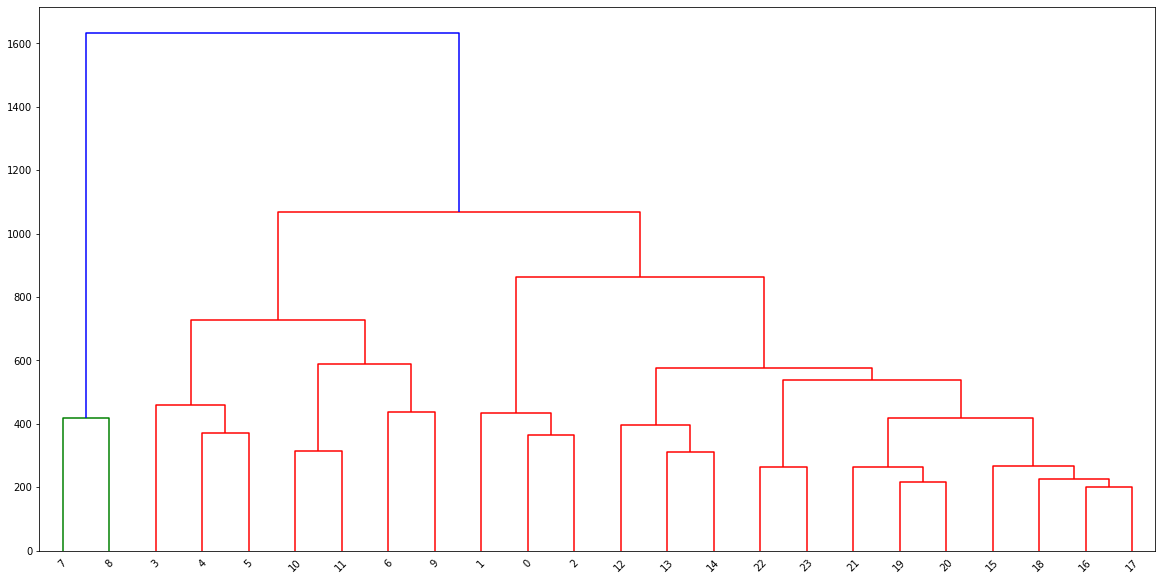

In [46]:
plt.figure(figsize=(20,10))
dendrogram(
        linkage(
        temp.iloc[:, 0:365],
        'ward'
    )
)
plt.show()